In [1]:
import pandas as pd
import cnets
from netgross.network import dirNetwork

import intensity_fill

%load_ext wurlitzer
%matplotlib inline

In [2]:
df = pd.read_csv("ravdess_features.csv")

excluded = [
    "modality",
    "vocal_channel",
    "emotional_intensity",
    "statement",
    "repetition",
     "actor",
    "channels",
    "sample_width",
    "frame_rate",
    "frame_width",
    "sample_width",
    "stft_max",
    "frame_count",
    "length_ms",
    "mean",
    "max","min",
    # "kur","skew",
]
df.drop(columns=excluded, inplace=True)
df = intensity_fill.fill_intensity(df)
for field in ["sex", "emotion"]:
    df[field] = pd.Categorical(df[field]).codes

/home/djanloo/Desktop/dynamiting/intensity_fill.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.intensity[df.intensity.isna()] = I_from_std(df["std"][df.intensity.isna()])


normalization

In [3]:
from sklearn.preprocessing import MinMaxScaler

X = df.values

scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

Manifold knn representation

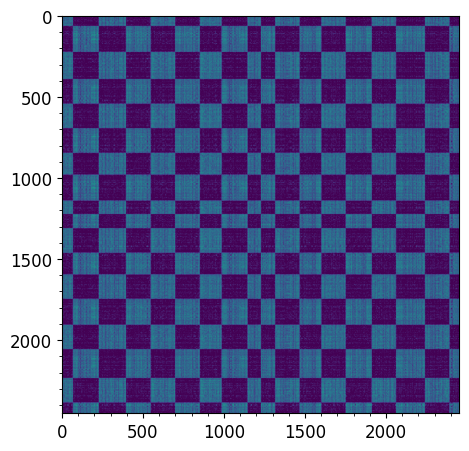

In [91]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import kneighbors_graph
A = kneighbors_graph(X_minmax,1000, mode='distance', include_self=True)
adj = A.toarray()
plt.imshow(adj)

This result is justified by the fact that the sex feature is divided in groups of males and females. This shows that the male cluster is completely disconnected from the female cluster.

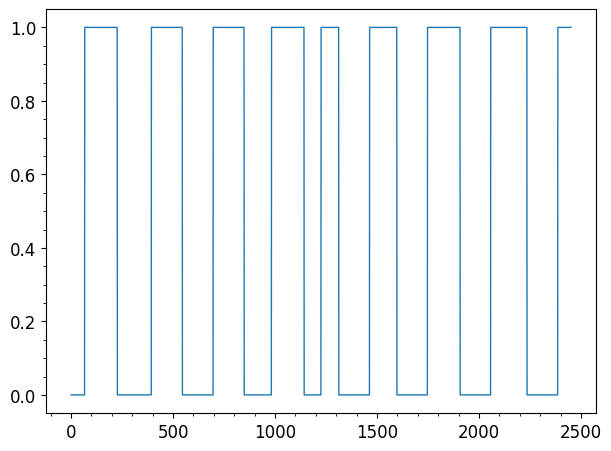

In [33]:
plt.plot(df.sex)

So we first compute the spectral embedding over the complete dataset

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


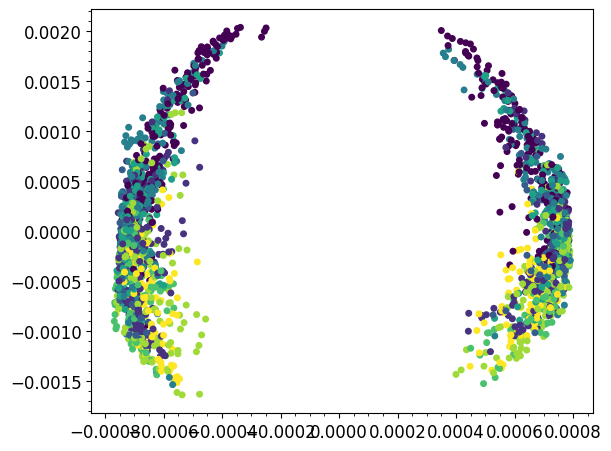

In [92]:
from sklearn.manifold import spectral_embedding
points = spectral_embedding(adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
plt.scatter(points[:,0], points[:,1], c=df.emotion)


Then we divide in males and females

/home/djanloo/.local/share/virtualenvs/dynamiting-oYIjB6ZE/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:233: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


(-0.0031500200261446757,
 0.003194829733999193,
 -0.0036571633683288754,
 0.003662950995904339)

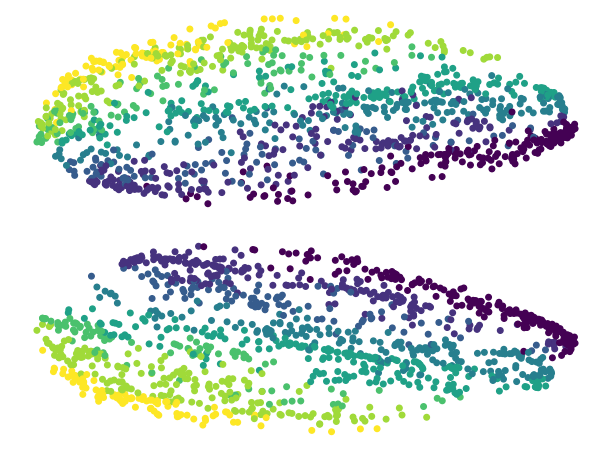

In [105]:
Xmales = X_minmax[df.sex==1]
Xfemales = X_minmax[df.sex==0]
K = 500
males_adj = kneighbors_graph(Xmales, K, mode='distance', include_self=True).toarray()
females_adj = kneighbors_graph(Xfemales, K, mode='distance', include_self=True).toarray()
male_points = spectral_embedding(males_adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
female_points = spectral_embedding(females_adj,  
                n_components=2, 
                eigen_tol=0.01, 
                norm_laplacian=True, 
                drop_first=True)
fig, axes = plt.subplots(2)
map = axes[0].scatter(male_points[:,0], male_points[:,1], c=df.emotion[df.sex==1])
axes[1].scatter(female_points[:,0], female_points[:,1], c=df.emotion[df.sex==0])
axes[0].axis("off")
axes[1].axis("off")